# Implementing LSH from scratch

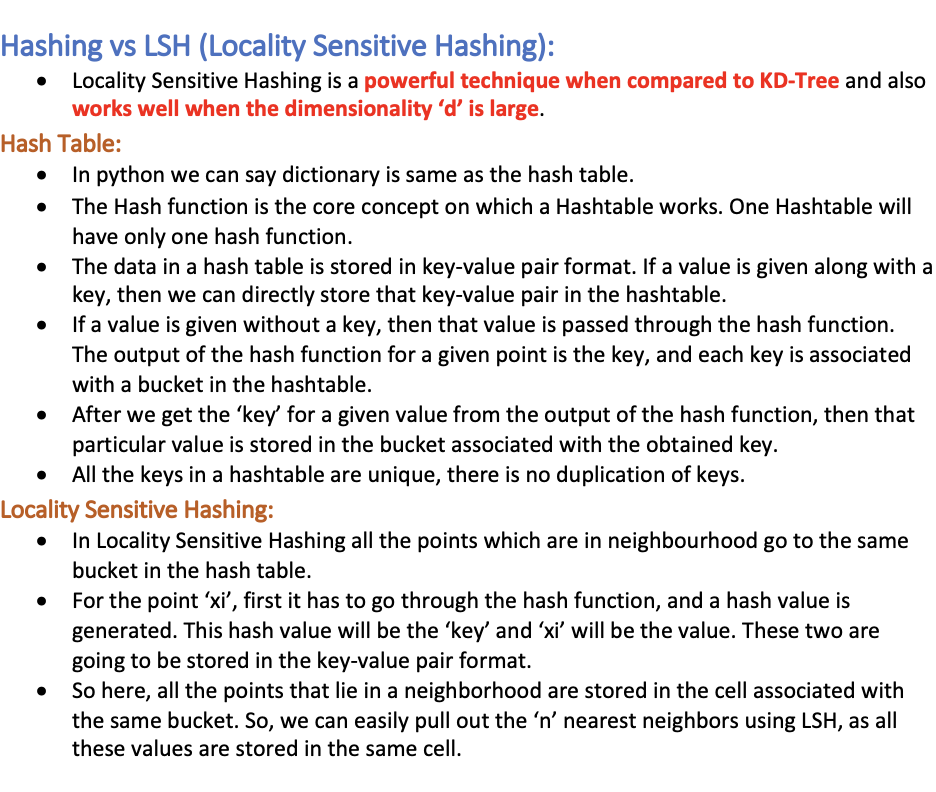



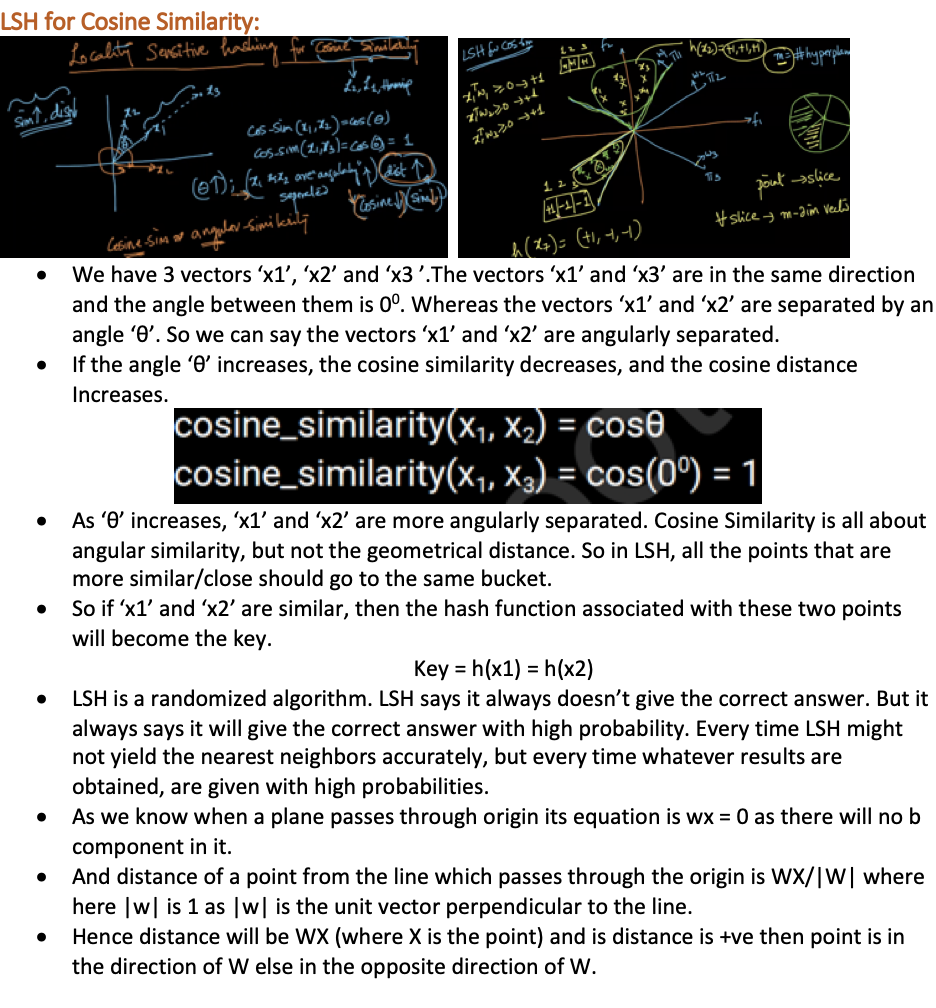

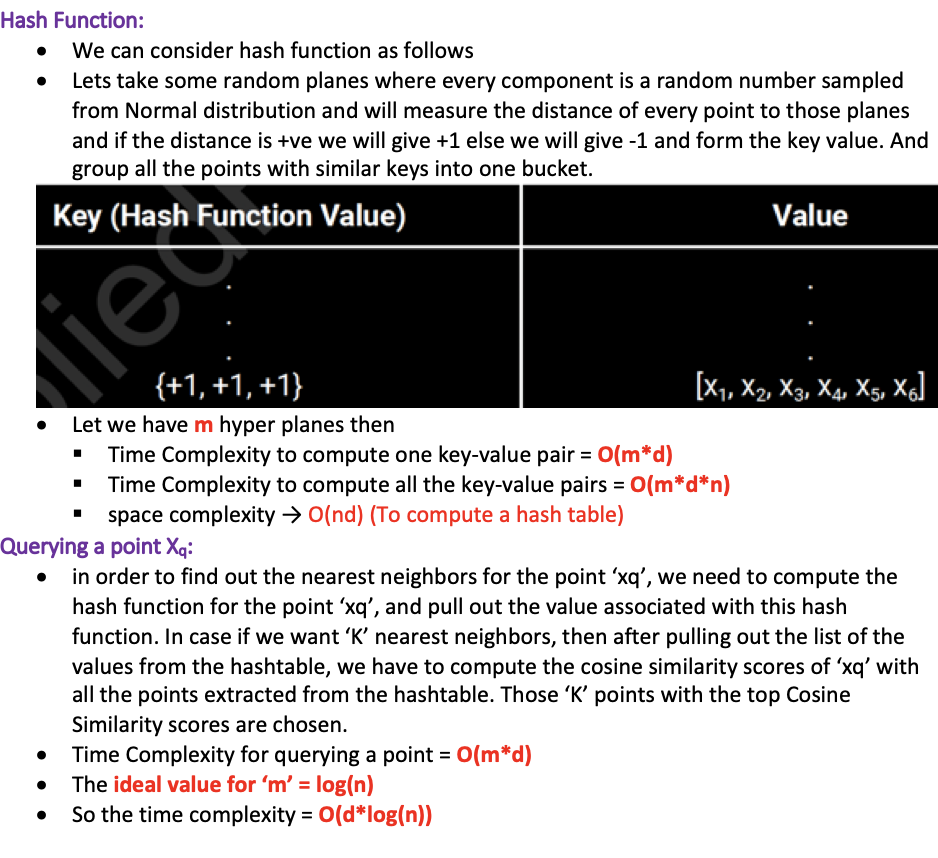

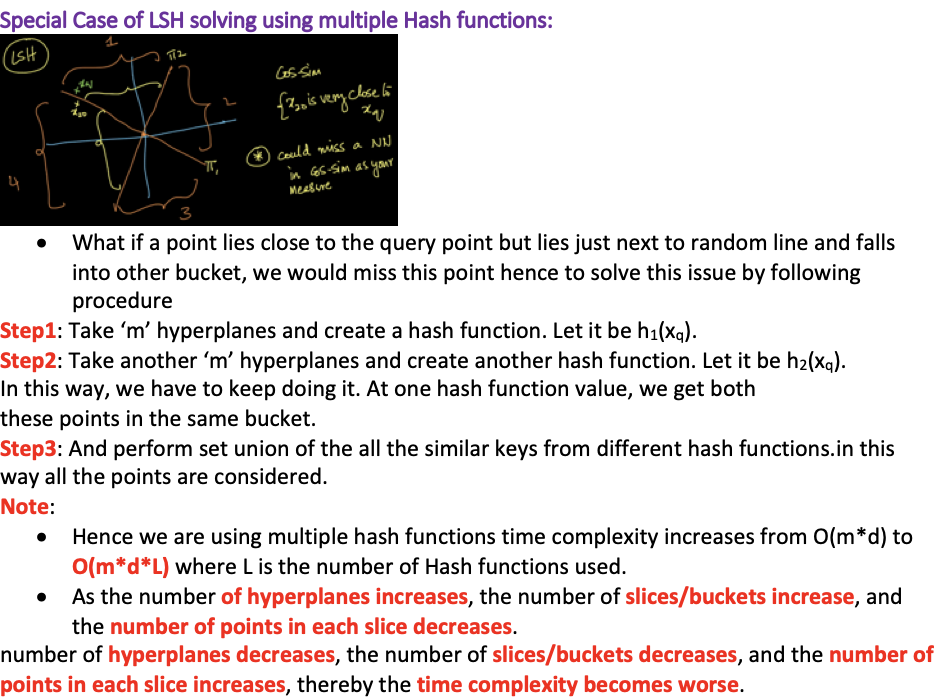

## Reading the data from csv file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading data from csv file
import pandas as pd
data_path = '/content/drive/MyDrive/knn/LSH_Sample_Data.csv'
df = pd.read_csv(data_path)
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,NaN,cars pull down us retail figures us retail sal...
2221,NaN,kilroy unveils immigration policy ex-chatshow ...
2222,NaN,rem announce new glasgow concert us band rem h...
2223,NaN,how political squabbles snowball it s become c...


In [4]:
# Data Overiview
df['category'].value_counts()

sport            509
business         508
politics         415
tech             399
entertainment    384
Name: category, dtype: int64

### Creating Train and Test Datasets

Note that the labels for test data will not be present in the dataset and hence they are mentioned as NaN.

In [5]:
# The last 10 rows in the csv file are query points, so loading them into test data.
# And loading the reamining points to train_data for which labels are given.

train_data = df.iloc[:-10,:]
test_data = df.iloc[-10:,:]

In [6]:
# For train_data here the labels are in the column named "category".
train_data

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2210,politics,teens know little of politics teenagers ques...
2211,entertainment,lopez misses uk charity premiere jennifer lope...
2212,business,christmas shoppers flock to tills shops all ov...
2213,tech,progress on new internet domains by early 2005...


In [7]:
test_data

,category,text
2215,NaN,junk e-mails on relentless rise spam traffic i...
2216,NaN,top stars join us tsunami tv show brad pitt r...
2217,NaN,rings of steel combat net attacks gambling is ...
2218,NaN,davies favours gloucester future wales hooker ...
2219,NaN,beijingers fume over parking fees choking traf...
2220,NaN,cars pull down us retail figures us retail sal...
2221,NaN,kilroy unveils immigration policy ex-chatshow ...
2222,NaN,rem announce new glasgow concert us band rem h...
2223,NaN,how political squabbles snowball it s become c...
2224,NaN,souness delight at euro progress boss graeme s...


## Custom Implementation

In [19]:
#Import Section
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import nltk
import numpy as np
nltk.download('wordnet')
nltk.download('omw-1.4')
from scipy import stats
from scipy import spatial
import collections
import statistics

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [9]:
# Preprocessing Step
def preprocessing(trainortest_data):
  preprocessed_reviews = []
  # tqdm is for printing the status bar
  for sentance in tqdm(trainortest_data):
    # No Https or html tags in text Values hence masking below step
    #sentance = re.sub(r"http\S+", "", sentance)
    #sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = re.sub(r"won't", "will not", sentance)
    sentance = re.sub(r"can\'t", "can not", sentance)
    # general
    sentance = re.sub(r"n\'t", " not", sentance)
    sentance = re.sub(r"\'re", " are", sentance)
    sentance = re.sub(r"\'s", " is", sentance)
    sentance = re.sub(r"\'d", " would", sentance)
    sentance = re.sub(r"\'ll", " will", sentance)
    sentance = re.sub(r"\'t", " not", sentance)
    sentance = re.sub(r"\'ve", " have", sentance)
    sentance = re.sub(r"\'m", " am", sentance)
    # Removing Words with Numbers if any 
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #Removing special Charectors observed $ , . , % , -, Â£ alot in data
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #Trying with stem using porter stemer , snow ball stemmer and word net lemmatiser and selecting the best one
    #ps = PorterStemmer()
    #snow_stemmer = SnowballStemmer(language='english')
    wordnet_lemmatizer = WordNetLemmatizer()
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords) 
    #sentance = ' '.join(ps.stem(e.lower()) for e in sentance.split() if ps.stem(e.lower()) not in stoppedwords)
    #sentance = ' '.join(snow_stemmer.stem(e.lower()) for e in sentance.split() if snow_stemmer.stem(e.lower()) not in stopwords) 
    sentance = ' '.join(wordnet_lemmatizer.lemmatize(e.lower()) for e in sentance.split())
    preprocessed_reviews.append(sentance.strip())
    # saving temp file to cloud
  '''%cd /gdrive/My Drive/
  pd.DataFrame(preprocessed_reviews).to_csv('check.csv')'''
  return preprocessed_reviews

In [27]:
# Hash Function
def hash_function(bin_bit_representation):
  '''we will get an example bin_bit_representation as [1,0,1,1,0] as we have 5 hyper planes now we will convert that using following hash function 
  let we have a vector [1,2,4,8,16] which is [2^0,2^1,2^2,2^3,2^4] as we will do dot product of our bin_bit_representation with [2^0,2^1,2^2,2^3,2^4] to get the hash keys ranging from 1 to 31 
  for our example our hash function convert [1,0,1,1,0] to 1*1+0*2+1*4+1*8+0*16 = 13'''
  hashfunctionreferencelist = 1 << np.arange(5 - 1, -1, step=-1) 
  bin_indices = bin_bit_representation.dot(hashfunctionreferencelist)
  return bin_indices


In [32]:
import numpy as np
def predictLabels (test_data):
  """
  Given the test_data, return the labels for all the rows in the test data.
  Follow the step by step instructions mentioned above.
  """
  np.random.seed(0)
  #Preprocessing the reviews
  preprocessed_reviews = train_data.text
  #-------------------------------TRAINING PHASE --------------------------------------------------#
  preprocessed_reviews = preprocessing(train_data.text)
  ''' as we are only considering bigrams and trigrams ngrams = (2,3), minimum document frequency is 10 and maximum number of features are 4000 and removing the english stop words if neccesary'''
  #vectorizer = TfidfVectorizer(ngram_range = (2,3),min_df = 10,max_features=4000,stop_words='english')
  vectorizer = TfidfVectorizer(ngram_range = (2,3),min_df = 10,max_features=4000)
  tf_idf_vector_processed_reviews = vectorizer.fit_transform(preprocessed_reviews)
  # generating the 5 hyper planes with the same dimension as tf_idf features
  random_hyper_planes = []
  for i in range(5):
    random_hyper_planes.append(np.random.normal(0,1,tf_idf_vector_processed_reviews.shape[1]))
  #initialising hash table
  hashtable=dict()
  for value in range(2**5):
    hashtable[value]=[]
  # converting every point in the training set to bitwise representation with 1 if it is in the direction of the wT and 0 if it is other direction and running it through hash function and identifiying the hashtable
  for review in tqdm(range(tf_idf_vector_processed_reviews.toarray().shape[0])):
    bin_vector = []
    for random_hyper_plane in random_hyper_planes:
      bin_vector.append(np.dot(random_hyper_plane,tf_idf_vector_processed_reviews[i][0].toarray()[0])>=0.0)
    hashtable[np.dot(bin_vector,[1,2,4,8,16])].append((tf_idf_vector_processed_reviews[review],train_data.category.values[review]))
  #-------------------------------TRAINING PHASE --------------------------------------------------#

  #-------------------------------TESTING PHASE --------------------------------------------------#
  testing_prediction = []
  #preprocessed_test_reviews = test_data.text
  preprocessed_test_reviews = preprocessing(test_data.text)
  tf_idf_vector_processed_test_reviews = vectorizer.transform(preprocessed_test_reviews)
  for review in tqdm(range(tf_idf_vector_processed_test_reviews.shape[0])):
    bin_vector = []
    for random_hyper_plane in random_hyper_planes:
      bin_vector.append(np.dot(random_hyper_plane,tf_idf_vector_processed_reviews[i][0].toarray()[0])>=0.0)
    # Identifying neighbor bins for each test Query point
    neighbouring_bins=list(hashtable[np.dot(bin_vector,[1,2,4,8,16])])
    # finding the cosine similarities of all the neighbouring points to the query point
    cosine_similarities = []
    for bin_point in range(len(neighbouring_bins)):
      # cosine_similarity(a,b) = dot(a.b)/||a||*||b||
      #cosine_similarity = 1 - spatial.distance.cosine(neighbouring_bins[bin_point].toarray()[0], tf_idf_vector_processed_test_reviews[review][0].toarray()[0])
      cosine_similarity = np.dot(neighbouring_bins[bin_point][0].toarray()[0],tf_idf_vector_processed_test_reviews[review][0].toarray()[0])/(np.linalg.norm(neighbouring_bins[bin_point][0].toarray()[0])*np.linalg.norm(tf_idf_vector_processed_test_reviews[review][0].toarray()[0]))
      cosine_similarities.append(cosine_similarity)
    # identifiying the cosine similarities of 11 nearest neighbours
    testing_prediction.append(list(neighbouring_bins[value][1] for value in np.argsort(cosine_similarities)[-11:]))
  # Finding the majority of the every element (list of 11 nearest neighbours of the query points) testing_prediction array and using alphabetical order in case of tie
  final_testing_pred=[]
  for query_predictions in testing_prediction:
    counter=list(collections.Counter(query_predictions).items())
    counter = sorted(list(collections.Counter(query_predictions).items()), key=lambda x: x[1],reverse=True)
    max = 0
    final_classlabel=""
    for counts in counter:
      if counts[1] > max :
        max = counts[1]
        final_classlabel = counts[0]
      elif counts[1] == max:
        final_classlabel = min(counts[0],final_classlabel)
      else:
        pass
    final_testing_pred.append(final_classlabel)
  print("")
  return final_testing_pred
  #-------------------------------TESTING PHASE --------------------------------------------------#


## Grader Cell

This cell will print "Success" if our implmentation of the predictLabels() is correct, else, it will print "Failed".

In [33]:
###########################################
## GRADER CELL: 
# This cell will print "Success" if our implmentation of the predictLabels() is correct and the accuracy obtained is above 80%.
# Else, it will print "Failed"
###########################################
import numpy as np

# Predict the labels using the predictLabels() function
Y_custom = np.array(predictLabels(test_data))

# Let Reference grader array 
Y_grader = np.array(['tech', 'entertainment', 'tech', 'sport', 'business', 'business', 'politics', 'entertainment', 'politics', 'sport'])

# Calculating accuracy by comparing Y_grader and Y_custom
accuracy = np.sum(Y_grader==Y_custom) * 10

if accuracy >= 80:
  print("******** Success ********","Accuracy Achieved = ", accuracy,'%')
else:
  print("####### Failed #######","Accuracy Achieved = ", accuracy,'%')
  print("\nY_grader = \n\n", Y_grader)
  print("\n","*"*50)
  print("\nY_custom = \n\n", Y_custom)


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


******** Success ******** Accuracy Achieved =  100 %
